
3000 * {"MCParticles.PDG": var * int32, "MCParticles.generatorStatus": var * int32, "MCParticles.simulatorStatus": var * int32, "MCParticles.charge": var * float32, "MCParticles.time": var * float32, "MCParticles.mass": var * float64, "MCParticles.vertex.x": var * float64, "MCParticles.vertex.y": var * float64, "MCParticles.vertex.z": var * float64, "MCParticles.endpoint.x": var * float64, "MCParticles.endpoint.y": var * float64, "MCParticles.endpoint.z": var * float64, "MCParticles.momentum.x": var * float32, "MCParticles.momentum.y": var * float32, "MCParticles.momentum.z": var * float32, "MCParticles.momentumAtEndpoint.x": var * float32, "MCParticles.momentumAtEndpoint.y": var * float32, "MCParticles.momentumAtEndpoint.z": var * float32, "MCParticles.spin.x": var * float32, "MCParticles.spin.y": var * float32, "MCParticles.spin.z": var * float32, "MCParticles.colorFlow.a": var * int32, "MCParticles.colorFlow.b": var * int32, "MCParticles.parents_begin": var * uint32, "MCParticles.p

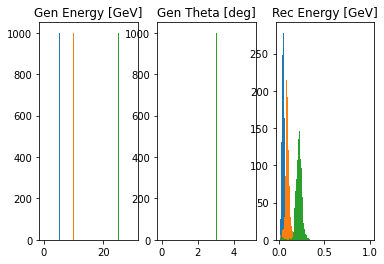

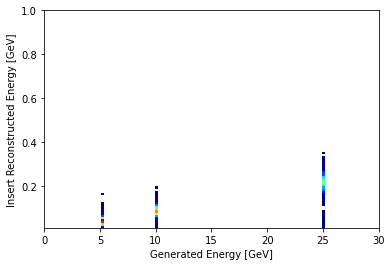

In [79]:
import uproot
import awkward as ak
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#load multiple ROOT files and get MCParticles and Insert branches
gen_arrays = uproot.concatenate(['input/rec_cal_output.5.root:events','input/rec_cal_output.10.root:events',
                                'input/rec_cal_output.25.root:events'],filter_name="MCParticles/*")
print("")
print(gen_arrays.type)
print("")

cal_arrays = uproot.concatenate(['input/rec_cal_output.5.root:events','input/rec_cal_output.10.root:events',
                                'input/rec_cal_output.25.root:events'],filter_name="HcalEndcapPInsertHits*")
print("")
print(cal_arrays.type)
print("")

#Get Primary (i.e. generated) particle information
print("Primary particle analysis...")
cut_primary = gen_arrays["MCParticles.generatorStatus"]==1 #cut to apply

gen_px = gen_arrays["MCParticles.momentum.x"][cut_primary]
gen_py = gen_arrays["MCParticles.momentum.y"][cut_primary]
gen_pz = gen_arrays["MCParticles.momentum.z"][cut_primary]
gen_mass = gen_arrays["MCParticles.mass"][cut_primary]

gen_pt = np.sqrt(gen_px**2+gen_py**2)
gen_mom = np.sqrt(gen_px**2+gen_py**2+gen_pz**2)
gen_energy = np.sqrt(gen_mom**2+gen_mass**2)
gen_theta = np.arccos(gen_pz/gen_mom)
gen_theta_deg = np.degrees(gen_theta)
gen_eta = -1.*np.log( np.tan(gen_theta/2.) )

#Get Calorimeter ADC value, hit energy, and hit time
adc = cal_arrays["HcalEndcapPInsertHitsDigi.amplitude"]
energy = cal_arrays["HcalEndcapPInsertHitsReco.energy"]
time = cal_arrays["HcalEndcapPInsertHitsReco.time"]

#Check that arrays have the same length for each event
print("ADC array length:")
print(ak.count(adc,axis=-1))
print("Energy array length:")
print(ak.count(energy,axis=-1))
print("Time array length:")
print(ak.count(time,axis=-1))

#Apply cut on ADC and time
cut_cal = (adc>450) & (time<200) 

print("")
print("Energy array before cut:")
print(energy)
print("Energy array after cut:")
energy_cut = energy[cut_cal] 
print(energy_cut)

#Sum energy hits for each event
sum_energy = ak.sum(energy_cut,axis=-1)
print("")
print("Energy sum after cut:")
print(sum_energy)
print("")
print("Generated Energy:")
print(ak.flatten(gen_energy))

#Loop over different generated energies
sim_energies = [5,10,25]
mycolor = ['red','blue']

fig, (ax1,ax2,ax3) = plt.subplots(1,3)

for sim_energy_sel in sim_energies:
    
    sel_cut = (gen_energy>sim_energy_sel-0.5) & (gen_energy<sim_energy_sel+0.5)
    
    gen_energy_sel = gen_energy[sel_cut]
    gen_theta_deg_sel = gen_theta_deg[sel_cut]
    sum_energy_sel = sum_energy[ak.flatten(sel_cut)]
    
    #Draw generated energy and angle
    ax1.hist(ak.flatten(gen_energy_sel),label="generated energy",bins=100,range=[0,30])
    ax1.set_title("Gen Energy [GeV]")
    ax2.hist(ak.flatten(gen_theta_deg_sel),label="generated theta",bins=100,range=[0,5])
    ax2.set_title("Gen Theta [deg]")

    #Draw reconstructed energy
    ax3.hist(sum_energy_sel,label="reconstructed energy",bins=100,range=[1e-2,1])
    ax3.set_title("Rec Energy [GeV]")

#Draw energy sum vs. generated energy (all energies)
plt.figure()
plt.hist2d(np.array(ak.flatten(gen_energy)),np.array(sum_energy),bins=(100,100),range=([0,30],[1e-2,1]),
           cmap=plt.cm.jet,cmin = 1)
plt.xlabel("Generated Energy [GeV]")
plt.ylabel("Insert Reconstructed Energy [GeV]")
plt.show()
